In [1]:
import os
from pathlib import Path
from typing import Any
import numpy as np
import torch as t
import torchvision
from einops import rearrange, repeat
from IPython.display import display
from PIL import Image
from scipy import linalg
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.transforms import CenterCrop, Compose, Lambda, RandomHorizontalFlip, Resize, ToPILImage, ToTensor
from tqdm.auto import tqdm
from w3d4_part1_diffusion_training_solution import NoiseSchedule, sample, train
from w3d4_part2_unet_solution import Unet

torch_device = 'cuda' if t.cuda.is_available() else "mps" if t.backends.mps.is_available() else "cpu"

MAIN = __name__ == "__main__"
IS_CI = os.getenv("IS_CI")


def make_transform(image_size=128):
    """Pipeline from PIL Image to Tensor."""
    return Compose([Resize(image_size), CenterCrop(image_size), ToTensor(), Lambda(lambda t: t * 2 - 1)])


def make_reverse_transform():
    """Pipeline from Tensor to PIL Image."""
    return Compose(
        [
            Lambda(lambda t: (t + 1) / 2),
            Lambda(lambda t: t.permute(1, 2, 0)),
            Lambda(lambda t: t * 255.0),
            Lambda(lambda t: t.clamp(0, 255)),
            Lambda(lambda t: t.numpy().astype(np.uint8)),
            ToPILImage(),
        ]
    )

ModuleNotFoundError: No module named 'w3d4_part1_diffusion_training_solution'

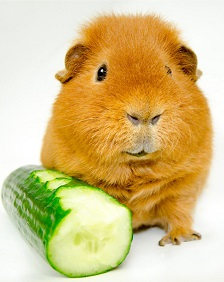

In [2]:
transform = make_transform()
reverse_transform = make_reverse_transform()
image = Image.open("./clip_images/guineapig_cucumber.jpg")
x = transform(image)
display(image)

In [3]:
def get_fashion_mnist(train_transform, test_transform) -> tuple[TensorDataset, TensorDataset]:
    """Return MNIST data using the provided Tensor class."""
    mnist_train = datasets.FashionMNIST("../data", train=True, download=True)
    mnist_test = datasets.FashionMNIST("../data", train=False)
    print("Preprocessing data...")
    train_tensors = TensorDataset(
        t.stack([train_transform(img) for (img, label) in tqdm(mnist_train, desc="Training data")])
    )
    test_tensors = TensorDataset(t.stack([test_transform(img) for (img, label) in tqdm(mnist_test, desc="Test data")]))
    return (train_tensors, test_tensors)


In [4]:
train_transform = Compose([ToTensor(), RandomHorizontalFlip(), Lambda(lambda t: t * 2 - 1)])
data_folder = Path("data/w3d4")
data_folder.mkdir(exist_ok=True, parents=True)
DATASET_FILENAME = data_folder / "generative_models_dataset_fashion.pt"
if DATASET_FILENAME.exists():
    (train_dataset, test_dataset) = t.load(str(DATASET_FILENAME))
else:
    (train_dataset, test_dataset) = get_fashion_mnist(train_transform, train_transform)
    t.save((train_dataset, test_dataset), str(DATASET_FILENAME))

/var/folders/sm/byz3skxx5c57sw2mzmy66j240000gn/T/ipykernel_97183/2678874312.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  (train_dataset, test_dataset) = t.load(str(DA

In [5]:
config_dict: dict[str, Any] = dict(
    model_channels=28,
    model_dim_mults=(1, 2, 4),
    image_shape=(1, 28, 28),
    max_steps=200,
    epochs=10,
    lr=0.001,
    batch_size=128,
    img_log_interval=400,
    n_images_to_log=3,
    device=torch_device,
)

In [6]:
model = Unet(
    max_steps=config_dict["max_steps"],
    channels=config_dict["model_channels"],
    image_shape=config_dict["image_shape"],
    dim_mults=config_dict["model_dim_mults"],
).to(config_dict["device"])
assert isinstance(data_folder, Path)
MODEL_FILENAME = data_folder / "unet_model.pt"
if MODEL_FILENAME.exists():
    model = Unet(
        max_steps=config_dict["max_steps"],
        channels=config_dict["model_channels"],
        image_shape=config_dict["image_shape"],
        dim_mults=config_dict["model_dim_mults"],
    ).to(config_dict["device"])
    model.noise_schedule = NoiseSchedule(config_dict["max_steps"], config_dict["device"])
    model.load_state_dict(t.load(str(MODEL_FILENAME)))
else:
    print("Training model from scratch!")
    model = train(model, config_dict, train_dataset, test_dataset)
    t.save(model.state_dict(), str(MODEL_FILENAME))

Channel sizes for in/out: [(28, 28), (28, 56), (56, 112)]
Channel sizes for in/out: [(28, 28), (28, 56), (56, 112)]


/var/folders/sm/byz3skxx5c57sw2mzmy66j240000gn/T/ipykernel_97183/3212782744.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t.load(str(MODEL_FILEN

100%|██████████| 200/200 [00:04<00:00, 49.82it/s]

Generated images: 


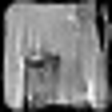

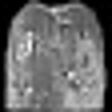

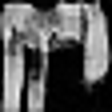

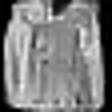

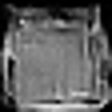

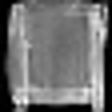

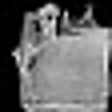

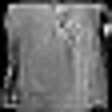

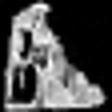

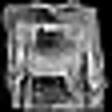

Training images: 


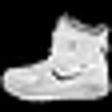

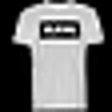

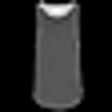

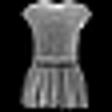

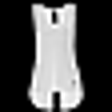

In [7]:
with t.inference_mode():
    samples = sample(model, n_samples=10)

assert isinstance(samples, t.Tensor)
print("Generated images: ")
for s in samples:
    img = reverse_transform(s.cpu())
    display(img.resize((4 * 28, 4 * 28)))

print("Training images: ")
(xs,) = train_dataset[:5]
for x in xs:
    display(reverse_transform(x).resize((4 * 28, 4 * 28)))


100%|██████████| 200/200 [00:03<00:00, 62.37it/s]


Printing sequential denoising: 
Step  0


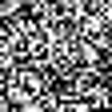

Step  10


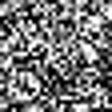

Step  20


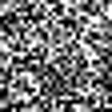

Step  30


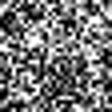

Step  40


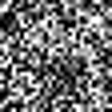

Step  50


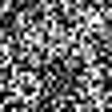

Step  60


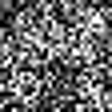

Step  70


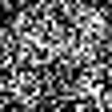

Step  80


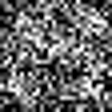

Step  90


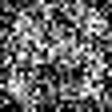

Step  100


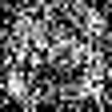

Step  110


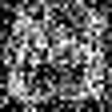

Step  120


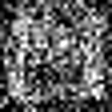

Step  130


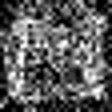

Step  140


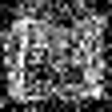

Step  150


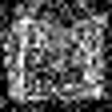

Step  160


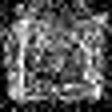

Step  170


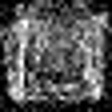

Step  180


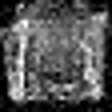

Step  190


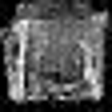

Step  200


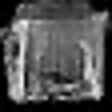

In [8]:
with t.inference_mode():
    samples = sample(model, n_samples=1, return_all_steps=True)

print("Printing sequential denoising: ")
for i, s in enumerate(samples):
    if i % (len(samples) // 20) == 0:
        print("Step ", i)
        img = reverse_transform(s[0].cpu())
        display(img.resize((4 * 28, 4 * 28)))